#### PI7-3: AE & VAE
This notebook contains all the implementation and evaluation of the research performed on autoencoders en variational autoencoders.

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

In [11]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [12]:
'''Adjustable constants'''
EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 0.03
LEARNING_RATE_GAMMA = 0.9

Z_DIM = 128

NUM_WORKERS = 4

In [13]:
class Encoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.z_space = z_space

        # (input)1->64, 64->128, 128->256, 256->z_space
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Conv2d(256, z_space, kernel_size=3, stride=2, padding=0, bias=False)
        )
        

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [14]:
class Decoder(nn.Module):
    def __init__ (self, z_space: int):
        super().__init__()
        self.z_space = z_space

        # z_space->256, 256->128, 128->64, 64->1 
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_space, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

'''
transforms.Normalize(mean=[0.5], std=[0.5])  # scale to [-1, 1]

Then change the final activation of your decoder from Sigmoid() to Tanh():

# Decoder last layer
nn.Tanh()

Why?

    Tanh outputs in [-1, 1] which matches the normalized input.

    This often results in sharper reconstructions and better gradients.
'''

'\ntransforms.Normalize(mean=[0.5], std=[0.5])  # scale to [-1, 1]\n\nThen change the final activation of your decoder from Sigmoid() to Tanh():\n\n# Decoder last layer\nnn.Tanh()\n\nWhy?\n\n    Tanh outputs in [-1, 1] which matches the normalized input.\n\n    This often results in sharper reconstructions and better gradients.\n'

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.encode = Encoder(z_space)
        self.decode = Decoder(z_space)

    def forward(self, X: torch.Tensor):
        z = self.encode(X)
        y = self.decode(z)
        
        return z, y

In [16]:
x = torch.randn(64, 1, 32, 32)
generator = AutoEncoder(z_space=20)
y, z = generator(x)
y.shape, z.shape

(torch.Size([64, 20, 1, 1]), torch.Size([64, 1, 32, 32]))

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [20]:
train_dir = 'data/cifar10_full/train'
test_dir = 'data/cifar10_full/test'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
testval_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

X_test_val, y_test_val = zip(*testval_dataset)

X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

splitval = int(0.5 * len(testval_dataset))

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [splitval, splitval])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test-Val dataset size: {len(testval_dataset)}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

TypeError: img should be Tensor Image. Got <class 'PIL.Image.Image'>

In [ ]:
generator = AutoEncoder(z_space=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.MSELoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        _, preds = generator(images)
        loss = criterion(preds, images)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        _, preds = generator(X_val.to(DEVICE))
        loss = criterion(preds, X_val.to(DEVICE))
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")


# TEST
with torch.no_grad():
    z, preds = generator(X_test.to(DEVICE))
    loss = criterion(preds, X_test.to(DEVICE))
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 0.027346298098564148, val_loss 0.020441515371203423
epoch 1, train_loss 0.01982731744647026, val_loss 0.0184919573366642
epoch 2, train_loss 0.0189217496663332, val_loss 0.017841821536421776
epoch 3, train_loss 0.018493687734007835, val_loss 0.018592169508337975
epoch 4, train_loss 0.018232660368084908, val_loss 0.017438214272260666
epoch 5, train_loss 0.01800435408949852, val_loss 0.01734629087150097
epoch 6, train_loss 0.01772448979318142, val_loss 0.017279744148254395
epoch 7, train_loss 0.017630813643336296, val_loss 0.017218874767422676
epoch 8, train_loss 0.01746140420436859, val_loss 0.017349354922771454
epoch 9, train_loss 0.017322836443781853, val_loss 0.017116528004407883
epoch 10, train_loss 0.017206544056534767, val_loss 0.01700521819293499
epoch 11, train_loss 0.01711409166455269, val_loss 0.017116164788603783
epoch 12, train_loss 0.017042456194758415, val_loss 0.016919119283556938
epoch 13, train_loss 0.016928406432271004, val_loss 0.016927264630794525

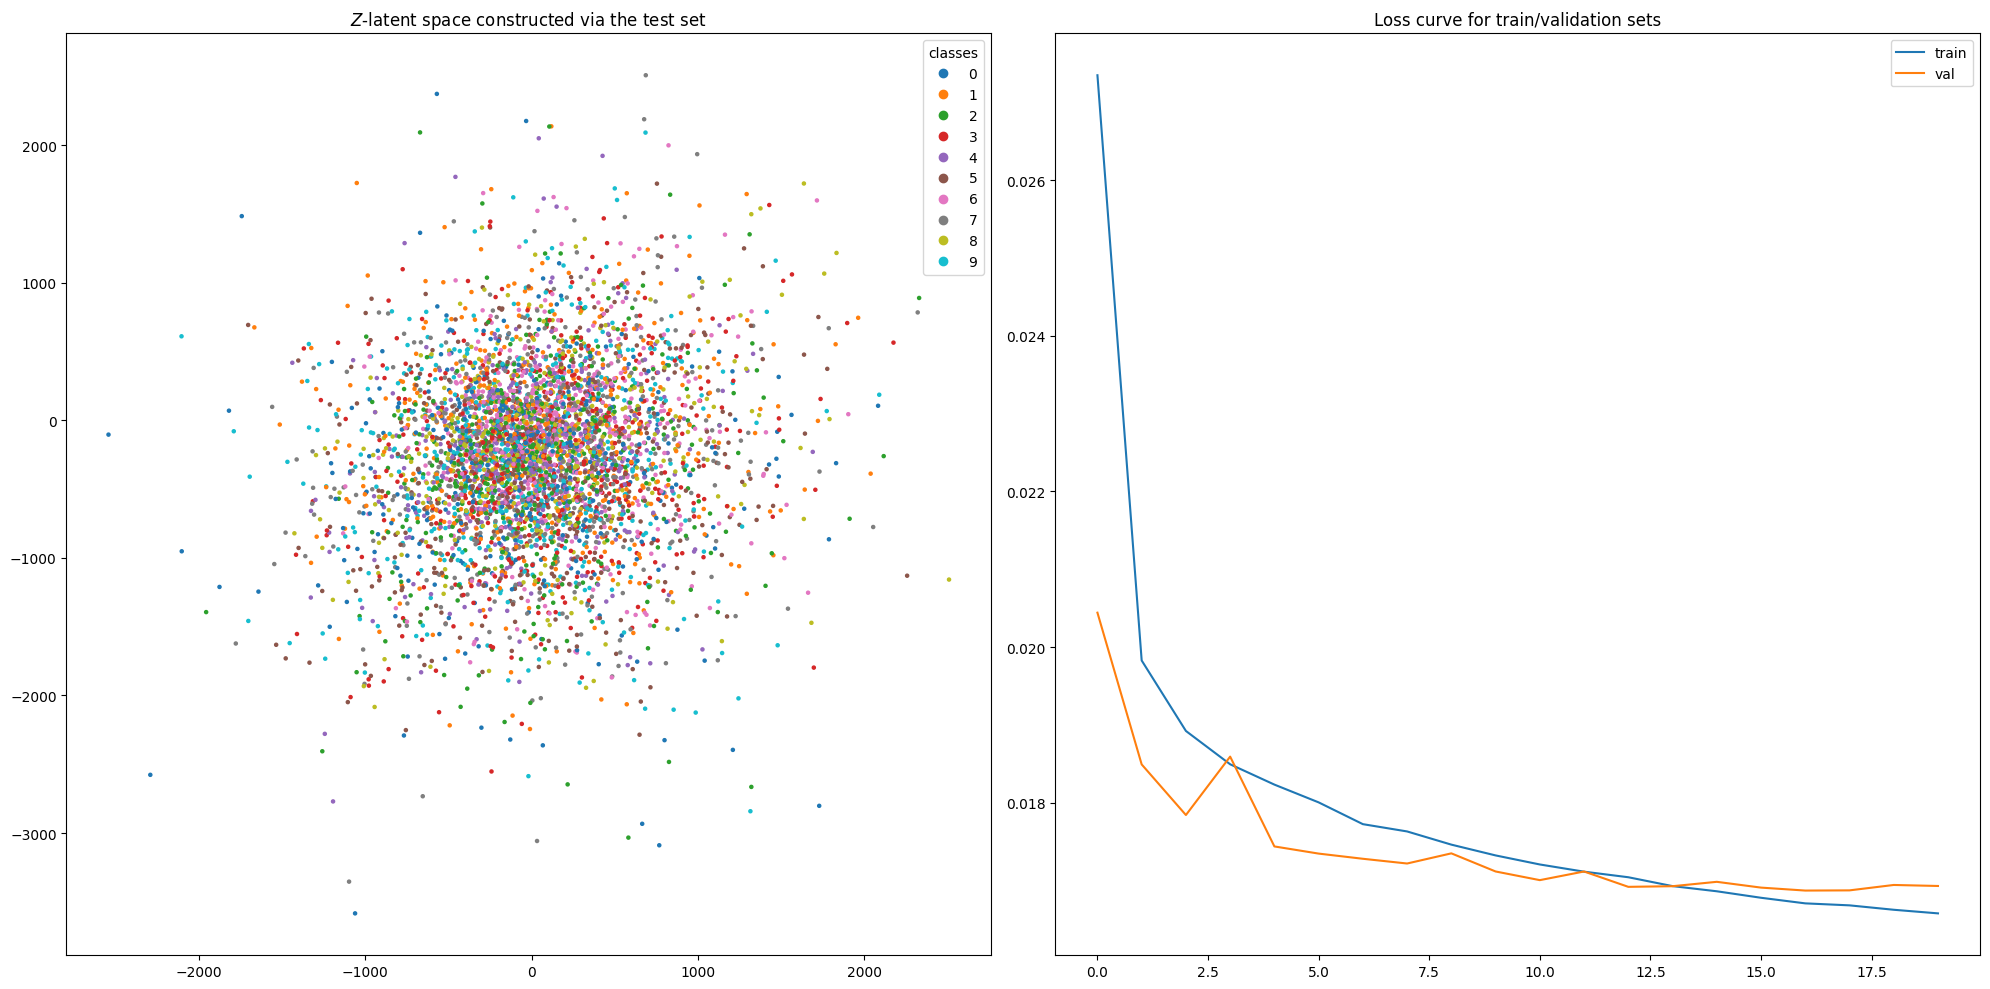

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Flatten z and move to numpy
z = z.view(z.shape[0], -1).cpu().detach().numpy()

# Apply t-SNE to reduce dimensionality
z_proj = TSNE(n_components=2, random_state=42).fit_transform(z)

# Plot t-SNE projection
sc = ax1.scatter(z_proj[:, 0], z_proj[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')
ax1.set_title("$Z$-latent space projected via t-SNE")

# Plot training and validation loss curves
ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()
ax2.set_title("Loss curve for train/validation sets")

plt.tight_layout()
plt.show()


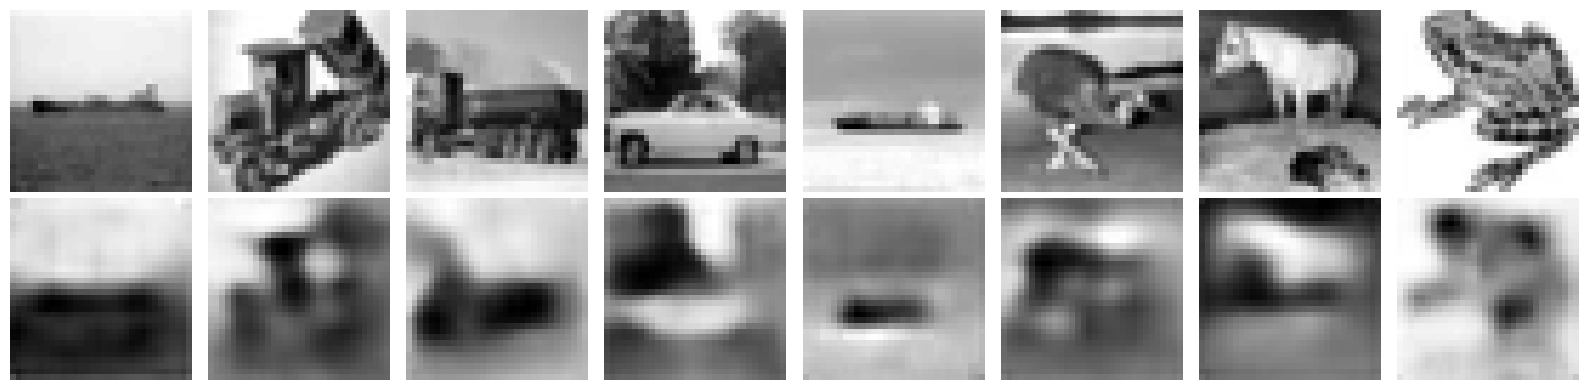

In [ ]:
generator.eval()
with torch.no_grad():
    _, recon = generator(X_val[:8].to(DEVICE))

recon = recon.cpu().squeeze().numpy()
original = X_val[:8].squeeze().numpy()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(original[i], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon[i], cmap='gray')
    axs[1, i].axis('off')
axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("Reconstructed", fontsize=12)
plt.tight_layout()
plt.show()